# Rating Classification

#### The purpose of this notebook is to use a custom dataset - 'RAW_interactions.csv' and to preprocess the reviews and ratings columns to be usable with DistilBERT model from Hugging Face. Then fine-tune said model according to the custom dataset to perform multi-labels classification (the ratings from 1-5).

### Setup

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Change working directory to be current folder
import os
os.chdir('/content/gdrive/My Drive/Food Recipe App/')
print("Current working directory:")
os.getcwd()
!ls

Current working directory:
 checkpoint		      RAW_recipes.csv
 checkpoints		      target_tensor_cpu.pickle
'Copy of transformer.ipynb'   target_tensor.pickle
 document_similarity.ipynb    targ_tokenizer_cpu.pickle
 inp_tokenizer_cpu.pickle     targ_tokenizer.pickle
 inp_tokenizer.pickle	      transformer_cpu.data-00000-of-00001
 input_tensor_cpu.pickle      transformer_cpu.index
 input_tensor.pickle	      transformer.data-00000-of-00001
 rating_classification	      transformer.index
 rating_classification2       transformer.ipynb
 RAW_interactions.csv	      wmd.model


In [3]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 5.5 MB/s 
     |████████████████████████████████| 59 kB 6.3 MB/s 
     |████████████████████████████████| 895 kB 35.8 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.29-py3-none-any.whl size=8613 sha256=e65606e31d93edc8a2d76cf0d59d0646f97b74928dfc48945fbfa593796c8b18
  Stored in directory: /root/.cache/pip/wheels/9e/2e/42/17cb826d143226e4d081aa33d3a9b9a90f234dfcf409824b87
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.26-py3-none-any.whl size=7612 sha256=ebd7f5d8513dcab7adfaefb7da1a5333a0861c26333bb80a94b0c355ff0beaa1
  Stored in directory: /root/.cache/pip/wheels/15/65/34/2e11a0da3cf6f112da5c402e01c454be619ff85a0fb38b3018
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4585 sha256=8438c4da42b230c18ab4a5111a3aee97cc83ff77ceff9759fcea118e9240cbfb
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [6]:
import pandas as pd
import tensorflow as tf

from plot_keras_history import plot_history
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

checkpoint = 'distilbert-base-uncased'

### Preprocess Custom Dataset

In [7]:
df = pd.read_csv("RAW_interactions.csv", usecols=['review', 'rating'])

# Drop rows that are NaN
df.dropna(subset=['review'], inplace=True)

# Keep rows that have string length >= 10
df = df[df['review'].str.split().str.len().ge(10)]

After inspection of the data, the author finds that many reviews with rating of '0' are not accurate. E.g. 

Review: This is a very good recipe. We also want to cut back on the fat content in our diet . Very tasty dish!!!


Rating: 0


As such, for consistency and brevity, rating '0' will not be included.

In [8]:
# Modify the dataframe to have 4000 data points for each rating (1-5)
df1 = df.loc[df['rating'] == 1].head(4000)
df2 = df.loc[df['rating'] == 2].head(4000)
df3 = df.loc[df['rating'] == 3].head(4000)
df4 = df.loc[df['rating'] == 4].head(4000)
df5 = df.loc[df['rating'] == 5].head(4000)

df_modified = pd.concat([df1, df2, df3, df4, df5])
print (df_modified)

      rating                                             review
83         1  I did not care for this at all. All I could ta...
121        1  I found this pudding, extremely discusting.  I...
130        1  What a disastrous recipe.  We used fat free yo...
192        1  This was incredibly sweet, and I reduced the s...
194        1  This was really terrible. It was overwhelmingl...
...      ...                                                ...
5796       5  This may sound very strange--but it is SO good...
5798       5  Boy, I sure missed out on a yummy treat when I...
5799       5  As long as it wasn't cooked spinach, I was hap...
5800       5  I love red skinned potatoes, and now I love th...
5801       5  My daughter announced at the dinner table that...

[20000 rows x 2 columns]


In [9]:
reviews = df_modified['review']
ratings = df_modified['rating']

In [10]:
def create_dataset(reviews, ratings):
  texts = []
  labels = []
  for review in reviews:
    texts.append(str(review))
  for rating in ratings:
    if rating == 1:
      labels.append([1,0,0,0,0])
    elif rating == 2:
      labels.append([0,1,0,0,0])
    elif rating == 3:
      labels.append([0,0,1,0,0])
    elif rating == 4:
      labels.append([0,0,0,1,0])
    elif rating == 5:
      labels.append([0,0,0,0,1])

  return texts, labels

In [11]:
texts, labels = create_dataset(reviews, ratings)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.33, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

In [12]:
# Tokenize the texts
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, return_tensors='tf')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors='tf')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors='tf')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [13]:
# Turn encodings and labels into a Dataset object
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

### Fine tune the model

In [14]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5, problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [15]:
batch_size = 8
num_epochs = 3

'''
- Decaying or annealing the learning rate via a learning rate scheduler.
- A good one to use is PolynomialDecay — despite the name, with default settings it simply linearly decays
the learning rate from the initial value to the final value over the course of training, which is exactly what we want.
- In order to use a scheduler correctly, though, we need to tell it how long training is going to be. We compute that as num_train_steps.
- num_train_steps is the number of samples in the dataset, divided by the batch size then multiplied by the total number of epochs.
'''
num_train_steps = (len(train_texts) // batch_size) * num_epochs
print (num_train_steps)
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.,
    decay_steps=num_train_steps
    )
opt = Adam(learning_rate=lr_scheduler)

'''
- Report training loss.
- Note, by default Keras will assume that you have already applied a softmax to your outputs. 
- Many models, however, output the values right before the softmax is applied, which are also known as the logits.
'''
loss = CategoricalCrossentropy(from_logits=True)

4020


In [16]:
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
hist_out_dp = model.fit(
    train_dataset.shuffle(1000).batch(8),
    validation_data=val_dataset.shuffle(1000).batch(8),
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/3
1340/1340 [==============================] - 1256s 927ms/step - loss: 1.0319 - accuracy: 0.5451 - val_loss: 0.9032 - val_accuracy: 0.5944
Epoch 2/3
1340/1340 [==============================] - 1242s 927ms/step - loss: 0.7787 - accuracy: 0.6621 - val_loss: 0.9022 - val_accuracy: 0.6138
Epoch 3/3
1340/1340 [==============================] - 1241s 926ms/step - loss: 0.5407 - accuracy: 0.7855 - val_loss: 0.9968 - val_accuracy: 0.6321


1340/1340 [==============================] - 395s 294ms/step - loss: 0.3633 - accuracy: 0.8799
Training Accuracy:  0.8799
825/825 [==============================] - 243s 295ms/step - loss: 1.0441 - accuracy: 0.5906
Testing Accuracy:  0.5906


(<Figure size 720x360 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f7f33c710>,
       dtype=object))

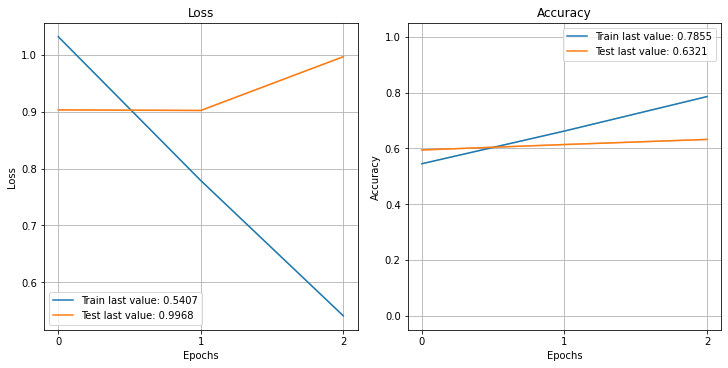

In [17]:
train_loss, train_accuracy = model.evaluate(train_dataset.shuffle(1000).batch(8), batch_size=8)
print("Training Accuracy:  {:.4f}".format(train_accuracy))
test_loss, test_accuracy = model.evaluate(test_dataset.shuffle(1000).batch(8), batch_size=8)
print("Testing Accuracy:  {:.4f}".format(test_accuracy))
plot_history(hist_out_dp)

In [ ]:
# Save model
model.save_pretrained("rating_classification2")

In [ ]:
# Load model
# model = TFAutoModelForSequenceClassification.from_pretrained("rating_classification2", num_labels=5, problem_type="multi_label_classification")
# model.compile(optimizer=opt, loss=loss)

Some layers from the model checkpoint at rating_classification were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at rating_classification and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sequences = [
  "This is the best recipe ever",
  "This is the worst recipe ever",
]

In [ ]:
se = tokenizer(sequences, truncation=True, padding=True, return_tensors='tf')

In [ ]:
output = model(se)

In [ ]:
predictions = tf.math.softmax(output.logits, axis=-1)
print(predictions)

tf.Tensor(
[[0.01833973 0.00470579 0.00417378 0.01747468 0.955306  ]
 [0.9761179  0.01374305 0.00239576 0.00120763 0.00653559]], shape=(2, 5), dtype=float32)
